# Test script to find all locations with large swirl

Aim is to take a velocity field, find all locations with large swirl, and then identify distinct blobs of swirl. 

This script makes use of the Source Extraction and Photometry (SEP) library

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload

In [2]:
f = h5py.File('/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2.mat')
#list(f.keys())

Swirl = np.asarray(f['Swirl'])
X  = np.asarray(f['X'])
Y  = np.asarray(f['Y'])

X = np.transpose(X,(1,0))
Y = np.transpose(Y,(1,0))
Swirl = np.transpose(Swirl,(2,1,0))

NanLocs = np.isnan(Swirl)

uSize = Swirl.shape

scale = (X[1,-1]-X[1,1])/(uSize[1]-1)

Cond = {k : f["Cond"][k].value[0]       #Generate a dictionary linking all values in cond with their names
     for k in f['Cond'].keys()}

Prof = {k : f["Prof"][k].value       #Generate a dictionary linking all values in cond with their names
     for k in f['Prof'].keys()}

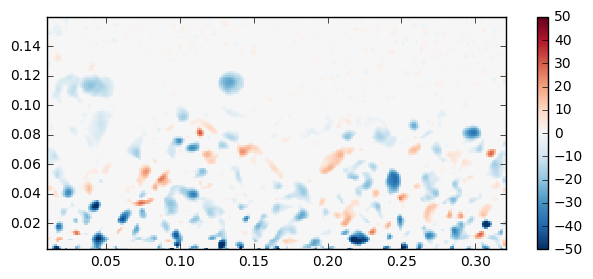

In [3]:
plt.figure(figsize = [8,3])
plt.pcolor(X,Y,Swirl[:,:,1], cmap='RdBu_r');
plt.clim([-50, 50])
plt.axis('scaled')
plt.xlim([X.min(), X.max()])
plt.ylim([Y.min(), Y.max()])
plt.colorbar()

# Normalize the swirl for distance from the wall (if wanted)

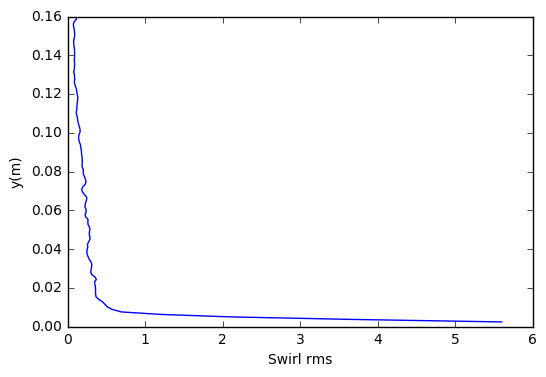

In [4]:
#Find profile of swirl std
SwirlStd = np.std(np.nanmean(Swirl,axis=2),axis = 1)
plt.plot(SwirlStd,Y[:,1])
plt.ylabel('y(m)')
plt.xlabel('Swirl rms')

In [5]:
#Normalize field by the std of Swirl
SwirlNorm = Swirl/SwirlStd.reshape(uSize[0],1,1) #match the SwirlStd length (123) with the correct index in Swirl (also 123)

# Plot after normalization

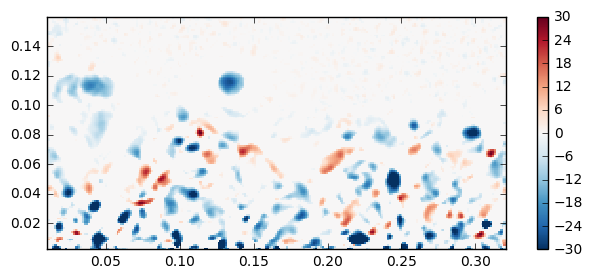

In [6]:
plt.figure(figsize = [8,3])
plt.pcolor(X,Y,Swirl[:,:,1], cmap='RdBu_r');
plt.clim([-30, 30])
plt.axis('scaled')
plt.xlim([X.min(), X.max()])
plt.ylim([Y.min(), Y.max()])
plt.colorbar()

In [7]:
Swirl[NanLocs] = 0   #Get rid of nans for now

# Create thresholded field

In [27]:
import copy

SwirlFilt = copy.copy(Swirl)    #think this should completely copy the list, allowing me to try things

#Swirl must be above a certain background value or it is zeroed
SwirlFilt[np.absolute(SwirlFilt)<7] = 0

#Then only keep those locations where swirls is greater than Thresh*SwirlStd
Thresh = 60
SwirlFilt[np.absolute(SwirlNorm)<Thresh] = 0

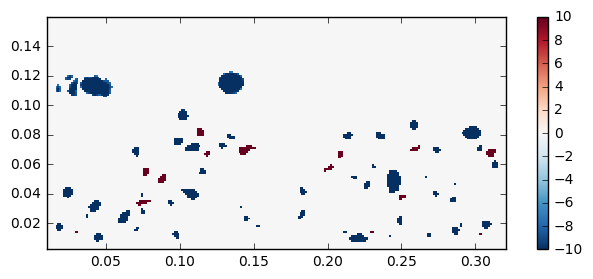

In [28]:
plt.figure(figsize = [8,3])
plt.pcolor(X,Y,SwirlFilt[:,:,1], cmap='RdBu_r');
plt.clim([-10, 10])
plt.axis('scaled')
plt.xlim([X.min(), X.max()])
plt.ylim([Y.min(), Y.max()])
plt.colorbar()

In [41]:
from scipy.ndimage.measurements import label,find_objects,center_of_mass

#SwirlFilt[SwirlFilt!=0] = 1 
#print(SwirlFilt)

labeled_array, num_features = label(SwirlFilt[:,:,1])
num_features
#labeled_array.ndim

66

/Users/Owen/anaconda/lib/python3.5/site-packages/scipy/ndimage/measurements.py:1284: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


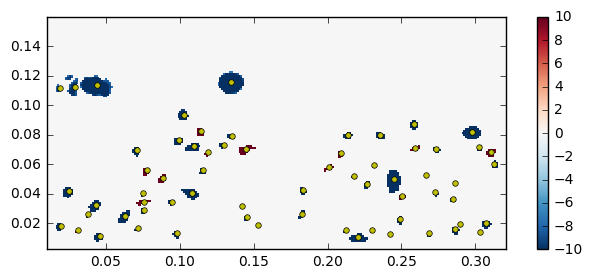

In [42]:
#label(SwirlFilt)

plt.figure(figsize = [8,3])
plt.pcolor(X,Y,SwirlFilt[:,:,1], cmap='RdBu_r');
plt.clim([-10, 10])
plt.axis('scaled')
plt.xlim([X.min(), X.max()])
plt.ylim([Y.min(), Y.max()])
plt.colorbar()

cent = center_of_mass(SwirlFilt[:,:,1],labeled_array,list(range(num_features)))
for i in range(num_features):
    plt.plot(cent[i][1]*scale+X[1,1],cent[i][0]*scale+Y[1,1],'oy',markersize=4,markeredgecolor=None)

In [50]:
# Now filter out all swirling motions that are too small 
loc = find_objects(labeled_array)
print(loc[3])
np.prod(labeled_array[loc[3]].shape)

(slice(7, 8, None), slice(180, 181, None))


1

In [51]:
ThreshSize = 50;

loc = find_objects(labeled_array)
labeled_array_init = copy.copy(labeled_array)
labeled_array[:] = 0;
num_features_init = copy.copy(num_features)
num_features = 0;
for i in range(num_features_init):
    if np.prod(labeled_array_init[loc[i]].shape)>ThreshSize:
        num_features += 1;
        labeled_array[labeled_array_init==i+1] = num_features
        
        

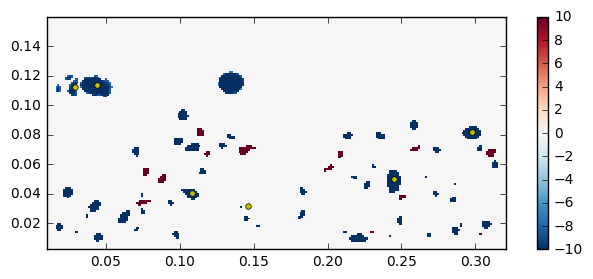

In [52]:
plt.figure(figsize = [8,3])
plt.pcolor(X,Y,SwirlFilt[:,:,1], cmap='RdBu_r');
plt.clim([-10, 10])
plt.axis('scaled')
plt.xlim([X.min(), X.max()])
plt.ylim([Y.min(), Y.max()])
plt.colorbar()

cent = center_of_mass(SwirlFilt[:,:,1],labeled_array,list(range(num_features)))
for i in range(num_features):
    plt.plot(cent[i][1]*scale+X[1,1],cent[i][0]*scale+Y[1,1],'oy',markersize=4,markeredgecolor=None)

In [36]:
cent

[(34.406488629200688, 120.77005291166734),
 (25.829406478601694, 213.12270735153916),
 (30.45314378862377, 134.19513744383545),
 (59.375985128988361, 174.93485415935703),
 (70.057560814080318, 71.344807588332458),
 (85.438626250266552, 25.52084596876357)]

In [37]:
find_objects(labeled_array)

[(slice(25, 28, None), slice(212, 215, None)),
 (slice(29, 33, None), slice(133, 137, None)),
 (slice(58, 62, None), slice(173, 178, None)),
 (slice(68, 74, None), slice(69, 75, None)),
 (slice(80, 92, None), slice(18, 35, None)),
 (slice(81, 90, None), slice(11, 17, None))]

In [17]:
(X[1,-1]-X[1,1])/(uSize[1]-1)

0.0012850504198509628

In [18]:
X[1,-1]-X[1,1]

0.30969715118408203

In [19]:
find_objects(labeled_array)

[(slice(25, 28, None), slice(212, 215, None)),
 (slice(29, 33, None), slice(133, 137, None)),
 (slice(58, 62, None), slice(173, 178, None)),
 (slice(68, 74, None), slice(69, 75, None)),
 (slice(80, 92, None), slice(18, 35, None)),
 (slice(81, 90, None), slice(11, 17, None))]

In [20]:
1:num_features

SyntaxError: invalid syntax (<ipython-input-20-f5a706e1d571>, line 1)

In [ ]:
linspace(1,num_features)

In [ ]:
list(range(num_features))

In [ ]:
range(num_features)